### Problem Statement

Build a project in the insurance domain. The goal of the project will be to build a robust generative search system capable of effectively and accurately answering questions from various policy documents. Using langchain to build the generative search application.


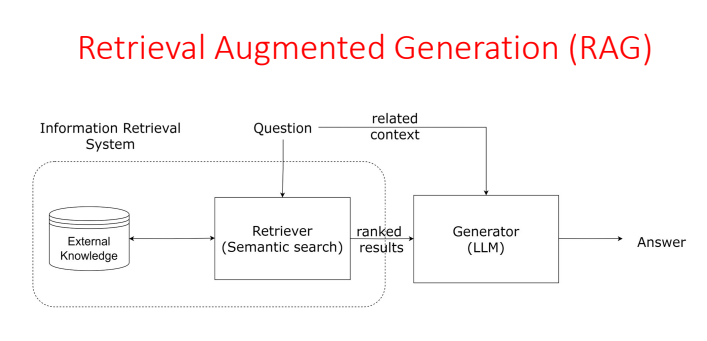

### RAG
**Retrieval-Augmented Generation** (RAG) is a method that improves the responses of a language model by using information from a knowledge base. It's like giving the model a library of information to reference when it's generating a response. This makes the model's responses more accurate and relevant.

RAG combines two types of models:
- ***retrieval models***, which pull data from a knowledge base, and
- ***generative models*** , which create the responses.

This combination makes RAG more powerful than a model that only generates responses. It can answer difficult questions and provide more informative responses.

###  LangChain

LangChain is ideal for building RAG systems because it provides a modular, flexible framework that separates data ingestion, embeddings, vector storage, retrieval, and LLM generation. It supports a wide range of embedding models and vector databases, offers advanced retrieval methods like MMR and compression retrievers, and simplifies orchestration through chains and agents. With strong prompt management, easy customization, and production-ready features such as caching, tracing, and evaluation, LangChain makes it simple to design, optimize, and deploy robust RAG pipelines.

- **RAG Agent** — performs semantic search through a tool; flexible and general-purpose.  
- **Lightweight RAG Chain** — uses a single LLM call per query; fast and effective for simple questions.

####  Key Concepts
- **Indexing:** Ingest and embed your data so it can be efficiently searched.  
- **Retrieval + Generation:** At query time, retrieve relevant documents and pass them to the LLM to generate accurate, grounded answers.

After indexing, an agent orchestrates the retrieval and generation steps to complete the RAG workflow.


#### Why Use **LangChain** for Your RAG System?

- **Model I/O** — Clean interfaces for LLMs, prompts, and structured outputs  
- **Retrieval** — Document loaders, transformers, embeddings, vector stores, and retrievers  
- **Chains** — Easy creation of multi-step LLM workflows  
- **Memory** — Persistent context for smarter, personalized responses  
- **Agents** — Enable dynamic tool and action selection  
- **Callbacks** — Logging, streaming, and full visibility into chain execution

**LangChain is a complete, modular, production-ready framework for powerful RAG systems.**




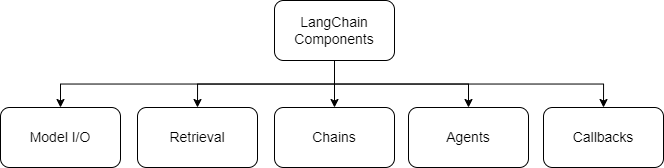

### 1. Model I/O

LangChain’s **Model I/O** module makes it easy to interface with LLMs and generate high-quality responses. It includes:

- **Language Models:** Unified interfaces for calling different LLMs  
- **Prompts:** Tools to template, manage, and dynamically generate prompts  
- **Output Parsers:** Utilities to structure and extract meaningful data from model outputs  

This component defines the core flow of how LangChain handles inputs and outputs when interacting with language models.


#### Importing and installing Necessary libraries

In [1]:
# Install required library
#!pip install pandas tiktoken chromadb openai google-generativeai langchain-google-genai langchain-huggingface langchain-core  transformers sentence_transformers

In [2]:
import os
os.environ["ANONYMIZED_TELEMETRY"] = "False"
import warnings
warnings.filterwarnings("ignore", message="Failed to send telemetry event")

In [3]:
import pandas as pd
import shutil
import tiktoken
import chromadb
import openai
from openai import OpenAI
import google.generativeai as genai
from langchain_google_genai import GoogleGenerativeAIEmbeddings
#from langchain.embeddings import HuggingFaceEmbeddings
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_core.prompts import PromptTemplate
from langchain_google_genai import ChatGoogleGenerativeAI

##### Set the OpenAI gemini complaint Key

In [4]:
# --------------------------
# Gemini client setup
# --------------------------
api_key = open('GEMINI_API_KEY.txt', 'r').read().strip()
openai_client = OpenAI(
    api_key=api_key,
    base_url="https://generativelanguage.googleapis.com/v1beta/openai/"
)

In [5]:
genai.configure(api_key=api_key)

In [6]:
# Set it in environment if not already set

os.environ["GOOGLE_API_KEY"] = api_key

#### 1. Data Connections and Retrieval

In addition to making API calls easier, LangChain also provides various methods to work with external documents efficiently.

Many LLM applications require user-specific data that is not part of the model's training set. The primary way of accomplishing this is through Retrieval Augmented Generation (RAG). In this process, external data is retrieved and then passed to the LLM when doing the generation step.

LangChain provides all the building blocks for RAG applications - from simple to complex. This section of the documentation covers everything related to the retrieval step - e.g. the fetching of the data. Although this sounds simple, it can be subtly complex. This encompasses several key modules.

The following methods provided by LangChain help process documents efficiently:
* Document Loaders
* Text Splitters
* Vector Stores
* Retrievers

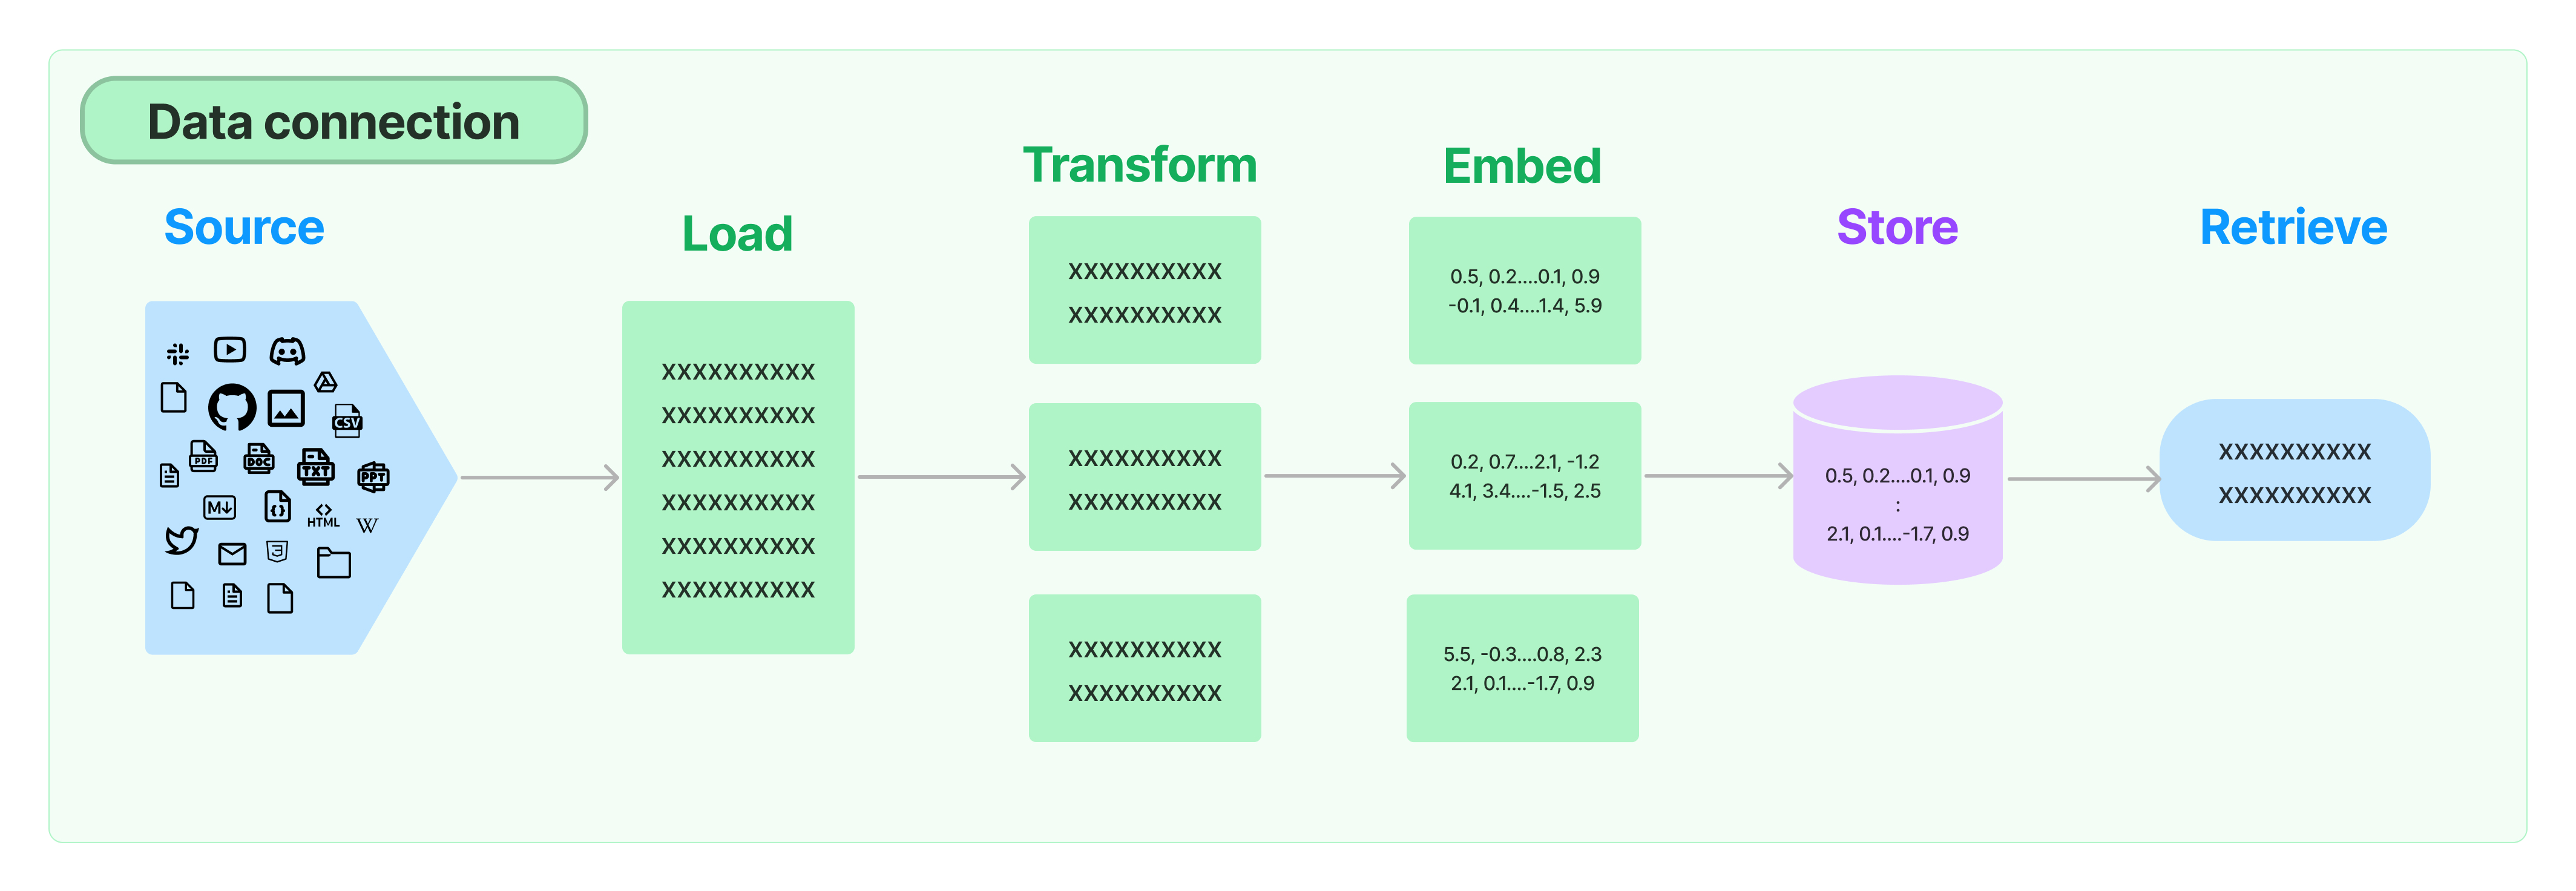

In [7]:
from langchain_community.document_loaders import PyPDFDirectoryLoader
import os

def load_pdfs_from_folder(folder_path: str):
    """
    Load all PDF documents from a given folder using PyPDFDirectoryLoader.

    Parameters
    ----------
    folder_path : str
        Path to the directory containing PDF files.

    Returns
    -------
    list
        A list of LangChain Document objects loaded from the PDFs.
    """
    if not os.path.isdir(folder_path):
        raise ValueError(f"Folder does not exist: {folder_path}")

    loader = PyPDFDirectoryLoader(folder_path)
    documents = loader.load()
    return documents


In [8]:
folder_path = './'
os.chdir(folder_path)

In [9]:
documents = load_pdfs_from_folder(folder_path + '/Policy+Documents')

In [10]:
# print details and first 100 lines from each docucment
for doc in documents:
    print(f"Source: {doc.metadata['source']}")
    print(f"Page Number: {doc.metadata['page']}")
    #print(f"Content: {doc.page_content[:100]}...")  # Displaying the first 100 characters

Source: Policy+Documents/HDFC-Life-Group-Term-Life-Policy.pdf
Page Number: 0
Source: Policy+Documents/HDFC-Life-Group-Term-Life-Policy.pdf
Page Number: 1
Source: Policy+Documents/HDFC-Life-Group-Term-Life-Policy.pdf
Page Number: 2
Source: Policy+Documents/HDFC-Life-Group-Term-Life-Policy.pdf
Page Number: 3
Source: Policy+Documents/HDFC-Life-Group-Term-Life-Policy.pdf
Page Number: 4
Source: Policy+Documents/HDFC-Life-Group-Term-Life-Policy.pdf
Page Number: 5
Source: Policy+Documents/HDFC-Life-Group-Term-Life-Policy.pdf
Page Number: 6
Source: Policy+Documents/HDFC-Life-Group-Term-Life-Policy.pdf
Page Number: 7
Source: Policy+Documents/HDFC-Life-Group-Term-Life-Policy.pdf
Page Number: 8
Source: Policy+Documents/HDFC-Life-Group-Term-Life-Policy.pdf
Page Number: 9
Source: Policy+Documents/HDFC-Life-Group-Term-Life-Policy.pdf
Page Number: 10
Source: Policy+Documents/HDFC-Life-Group-Term-Life-Policy.pdf
Page Number: 11
Source: Policy+Documents/HDFC-Life-Group-Term-Life-Policy.pdf
Page Number:

### **Document Transformers / Text Splitters**
Often times your document is too long (like a book) for your LLM. You need to split it up into chunks. Text splitters help with this.

There are many ways you could split your text into chunks, experiment with [different ones](https://python.langchain.com/en/latest/modules/indexes/text_splitters.html) to see which is best for you.

LangChain offers different text splitters for splitting the data such as:
* Split by Character
* Recursive Splitter
* Token Splitter

**Split by Character** - This is the simplest method. This splits based on characters (by default "\n\n") and measure chunk length by number of characters.
* How the text is split: by single character.
* How the chunk size is measured: by number of characters.

**Recursive Text Splitter** - This text splitter is the recommended one for generic text. It is parameterized by a list of characters. It tries to split on them in order until the chunks are small enough. The default list is ["\n\n", "\n", " ", ""]. This has the effect of trying to keep all paragraphs (and then sentences, and then words) together as long as possible, as those would generically seem to be the strongest semantically related pieces of text.
* How the text is split: by list of characters.
* How the chunk size is measured: by number of characters.

**Split by tokens** - Language models have a token limit. You should not exceed the token limit. When you split your text into chunks it is therefore a good idea to count the number of tokens. There are many tokenizers. When you count tokens in your text you should use the same tokenizer as used in the language model.

In [11]:
def split_into_chunks(documents, splitter):
    """
    Splits documents into chunks using the provided text splitter.

    Args:
        documents (list): A list of Document objects.
        splitter: A LangChain text splitter instance (e.g., RecursiveCharacterTextSplitter).

    Returns:
        list: A list of split Document chunks.
    """
    return splitter.split_documents(documents)


In [12]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

# Create the text splitter
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=200
)


In [13]:
splits = split_into_chunks(documents, text_splitter)

In [14]:
# Optional: check how many chunks were created
print(f"Total chunks: {len(splits)}")

Total chunks: 760


In [15]:
# print a sample chunk
print(splits[2])

page_content='purchased HDFC Life Insurance Policy:  
 
 Policy Schedule   :  Summary of key features of your HDFC Life Insurance Policy 
 Premium Receipt   :  Acknowledgement of the first Premium paid by you 
 Terms & Conditions  :  Detailed terms of your Policy contract with HDFC Life                                                               
                                                    Insurance 
 Service Options  :  Wide range of Policy servicing options that you can Benefit 
from 
 
We request you to carefully go through the information given in this document. You are also advised to 
keep the Policy Bond with utmost care and safety because this document will be required at the time 
of availing Policy Benefits.  In case of employer -employee relationship and the policy has been issued 
in the benefit of employee you are advised to communicate to the employee on the details of insurance' metadata={'producer': 'Microsoft® Office Word 2007', 'creator': 'Microsoft® Off

In [16]:
print ("Text Preview:") # Preview the split texts and the character count
print (splits[0].page_content,"-", len(splits[0].page_content), "\n")
print (splits[1].page_content,"-", len(splits[1].page_content), "\n")
print (splits[2].page_content,"-", len(splits[2].page_content), "\n")
print (splits[3].page_content,"-", len(splits[3].page_content), "\n")
print (splits[4].page_content,"-", len(splits[4].page_content), "\n")
print (splits[5].page_content,"-", len(splits[5].page_content), "\n")

Text Preview:
F&U dated 15th October 2022                  UIN-101N169V02  P a g e  | 0                        
 
 
 
 
 
   HDFC Life Group Term Life 
 
OF 
 
 
«OWNERNAME» 
 
 
 
 
 
  
Based on the Proposal and the declarations and 
any 
statement made or referred to therein, 
We will pay the Benefits mentioned in this Policy 
subject to the terms and conditions contained 
herein 
 
 
 
 
 
 
<< Designation of the Authorised Signatory >> - 430 

F&U dated 15th October 2022                  UIN-101N169V02  P a g e  | 1                        
 
 
PART A: Covering Letter with Policy Schedule 
                                                                                                                                                <dd-mm-yyyy> 
__________________ 
__________________ 
__________________ 
__________________ 
__________________ 
 
 
Your HDFC Life <Policy Name> with Policy No. <Policy no.> 
 
Dear Mr./Ms.___________________________, 
 
We thank you for choosing HDFC L

### [Text Embedding Models](https://python.langchain.com/docs/modules/data_connection/text_embedding/)

The Embeddings class is a class designed for interfacing with text embedding models. LangChain provides support for most of the embedding model providers (OpenAI, huggingface) including sentence transformers library from Hugging Face.

Embeddings create a vector representation of a piece of text and supports all the operations such as similarity search, text comparison, sentiment analysis etc.

The base Embeddings class in LangChain provides two methods: one for embedding documents and one for embedding a query.

The first method takes as input multiple texts, while the second method returns the embedding representation for a single text.


In [17]:
huggingface_embedding_model = "sentence-transformers/all-MiniLM-L6-v2"
embeddings_model = HuggingFaceEmbeddings(model_name=huggingface_embedding_model)


##### doing a sample embedding of a random chunk, to check size


In [18]:
embeddings = embeddings_model.embed_documents([splits[0].page_content])


In [19]:
type(embeddings)

list

### Vector Stores

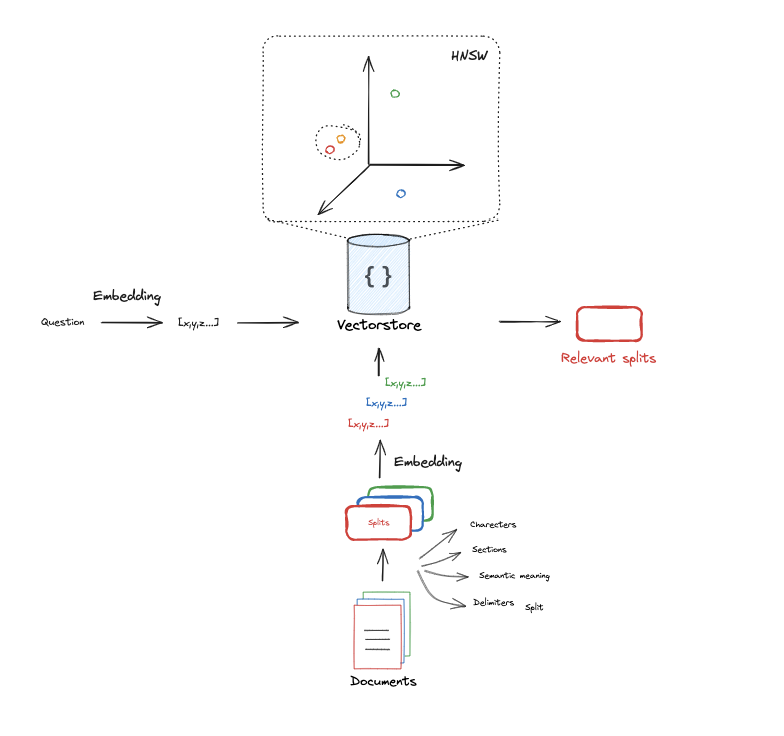

### Caching

Embeddings can be stored or temporarily cached to avoid needing to recompute them.
Caching embeddings can be done using a **CacheBackedEmbeddings**. This wrapper stores embeddings in a key-value store, where the text is hashed and the hash is used as the key in the cache.
The main supported way to initialize a CacheBackedEmbeddings is from_bytes_store. It takes the following parameters:
underlying_embedder: The embedder to use for embedding.
document_embedding_cache: Any ByteStore for caching document embeddings.
batch_size: (optional, defaults to None) The number of documents to embed between store updates.
namespace: (optional, defaults to "") The namespace to use for the document cache. Helps avoid collisions (e.g., set it to the embedding model name).
query_embedding_cache: (optional, defaults to None) A ByteStore for caching query embeddings, or True to reuse the same store as document_embedding_cache

In [20]:

from langchain_classic.embeddings import CacheBackedEmbeddings
from langchain_classic.storage import LocalFileStore

def get_cached_embeddings(embedding_model, cache_dir="./cache/", refresh=False):
    """
    Wrap an embedding model with cache-backed embeddings stored in a local file.

    Args:
        embedding_model: Any LangChain embedding model (e.g., HuggingFaceEmbeddings, OpenAIEmbeddings)
        cache_dir (str): Directory to store cached embeddings locally

    Returns:
        CacheBackedEmbeddings: A cached embedding wrapper
    """

    # Clear cache if refresh is True
    if refresh:
        shutil.rmtree(cache_dir, ignore_errors=True)
    
    # Create local file store
    store = LocalFileStore(cache_dir)

    # Create cache-backed embeddings
    cached_embedder = CacheBackedEmbeddings.from_bytes_store(
        embedding_model,
        store,
        namespace=getattr(embedding_model, "model_name", getattr(embedding_model, "model", "default_namespace"))
    )

    return cached_embedder


In [21]:
cached_embeddings = get_cached_embeddings(embeddings_model, refresh=True)

/Users/amit.kumar/ws/upgrad/c71/misc-kernal/nlp/lib/python3.13/site-packages/langchain_classic/embeddings/cache.py:58: UserWarning: Using default key encoder: SHA-1 is *not* collision-resistant. While acceptable for most cache scenarios, a motivated attacker can craft two different payloads that map to the same cache key. If that risk matters in your environment, supply a stronger encoder (e.g. SHA-256 or BLAKE2) via the `key_encoder` argument. If you change the key encoder, consider also creating a new cache, to avoid (the potential for) collisions with existing keys.
  _warn_about_sha1_encoder()


#### Vector stores
A vector store stores embedded data and performs similarity search

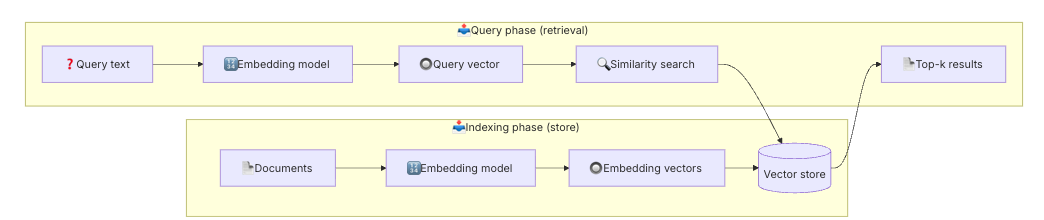

In [22]:
from langchain_chroma import Chroma

def get_chroma_vector_store(cached_embeddings, collection_name="insurance_collection", persist_dir="./chroma_langchain_db", refresh=False):
    """
    Create a persistent Chroma vector store with optional refresh.

    Args:
        cached_embeddings: CacheBackedEmbeddings or any LangChain embedding function
        collection_name (str): Name of the collection
        persist_dir (str): Directory to persist Chroma DB
        refresh (bool): If True, clears the existing Chroma DB before creating a new one

    Returns:
        Chroma: Chroma vector store instance
    """
    # Clear existing database if refresh is True
    if refresh:
        shutil.rmtree(persist_dir, ignore_errors=True)

    # Ensure directory exists
    os.makedirs(persist_dir, exist_ok=True)
    
    # Create Chroma vector store
    vector_store = Chroma(
        collection_name=collection_name,
        embedding_function=cached_embeddings,
        persist_directory=persist_dir
    )

    return vector_store

In [23]:
# Refresh Chroma DB and rebuild from scratch
vector_store = get_chroma_vector_store(cached_embeddings, refresh=True)


In [24]:
from langchain_classic.docstore.document import Document


In [26]:
# Add the split documents directly
vector_store.add_documents(splits)

['a3fa89c4-c06c-47b2-b075-ba40cd0030d8',
 'd262b498-0850-43d5-a5f3-85c333490700',
 '251af874-27d2-416b-9d79-25c3c5e0ac7f',
 '47789326-dc4c-4b2a-be4d-d3e2f7a153a1',
 '37559c84-c78f-4585-8c36-5e7cfafd7c25',
 '8e454488-c2f0-45e0-8627-4f0e1c179abd',
 'ee0b5c5b-cb91-4e25-91c5-62dc103106f7',
 '239f3d27-27fa-4eb1-b187-6dbd895487fe',
 'd9b1baa7-0f3f-4cbd-bb25-8a50685ba9d9',
 '2854590b-2ac4-4129-aa59-59d6dc1c8d71',
 'e52222a5-6c5b-4668-8078-e3f0244ad157',
 'ec70f7ce-04de-41d1-be27-61d2f011db78',
 '0a8eb853-b70d-43c0-b138-7aeabd6e1e9c',
 '951cffaf-bfc2-4023-ad4f-eb192f69bea7',
 '5b80e8ae-0ed1-4915-9e4a-1a01daea5407',
 '97830421-50ef-4c86-97d1-9a240fc08702',
 '6600d33d-b4e1-4d1b-8cf1-f8250dfb6ecf',
 '263d7487-0049-4008-a771-f39107f38446',
 '71de8771-04d0-45a6-9d1e-5eb1d75cfe5a',
 '3d7d6af7-6aa2-4e70-8847-c6aadb8ab81e',
 'ac2a8397-ddf4-4051-a216-b94d5be66e2b',
 '91c8b2d8-31a2-45cf-a8f6-6274d00d4b86',
 '6a91780c-85d4-4bf0-b8ae-304f0407b275',
 'cbb0c585-eba2-4fd2-9d62-92f08764ee15',
 '44057b79-251f-

Perform Similarity Search

In [27]:
def similarity_search(query):
    return vector_store.similarity_search(query, k=2)

docs =  similarity_search("what is the life insurance coverage for sport injury?")
print(docs[0])

page_content='accordance with the lawful directions and prescription of a registered medical practitioner. 
 Engaging in or taking part in professional sport(s) or any hazardous pursuits, power boat racing, sky 
diving, para gliding, parachuting, scuba diving, skydo riding, winter sports, sky jumping, ice hockey, 
ice speedway, ballooning, hand gliding, river rafting / bugging, black water rafting, yachting / 
boating outside coastal waters, motor rallying, power lifting, quad biking, rodeo and roller hockey. 
 War, invasion, hostilities (whether war is declared or not), civil war, rebellion, revolution or taking 
part in a riot or civil commotion. 
 Taking part in any flying activity, other than as a passenger in a commercially licensed aircraft. 
 Participation by the life assured in a criminal or unlawful act. 
 
 
2. Claims Procedure: 
(1) The Master Policyholder shall inform the Insurer within 30 days of the death/ illness of a Scheme' metadata={'source': 'Policy+Documents/HDF

LangChain also support all major vector stores and databases such as FAISS, ElasticSearch, LanceDB, Milvus, Pinecone etc. Refer to the [API documentation](https://api.python.langchain.com/en/latest/api_reference.html#module-langchain.vectorstores) for the complete list.

### **LLM Model**

In [34]:
from langchain_google_genai import ChatGoogleGenerativeAI

In [35]:
model = "gemini-2.5-flash"

llm = ChatGoogleGenerativeAI(
    model=model,
    temperature=0.2,
    max_tokens=None,
    timeout=None,
    max_retries=2
)


### **Retrievers**
Retrievers provide Easy way to combine documents with language models.


A retriever is an interface that returns documents given an unstructured query. It is more general than a vector store. A retriever does not need to be able to store documents, only to return (or retrieve) them. Retriever stores data for it to be queried by a language model. It provides an interface that will return documents based on an unstructured query. Vector stores can be used as the backbone of a retriever, but there are other types of retrievers as well.



There are many different types of retrievers, the most widely supported is the VectoreStoreRetriever.

The [official documentation](https://python.langchain.com/docs/integrations/retrievers/) and [API reference](https://api.python.langchain.com/en/latest/api_reference.html#module-langchain.retrievers) contains a list of retriever integrations supported by LangChan.

#### Set Up Contextual Compression and Reranking

Initialize a language model with Cohere, set the reranker with CohereRerank, and combine it with the base retriever in a ContextualCompressionRetriever. This setup compresses and reranks the retrieval results, refining the output based on contextual relevance.

After adding the re-ranker, the response of your RAG system will become more refined, which will not only improve the user experience but also reduce the number of tokens used.

In [52]:
from langchain_classic.retrievers import ContextualCompressionRetriever
from langchain_classic.retrievers.document_compressors import CrossEncoderReranker
from langchain_community.cross_encoders import HuggingFaceCrossEncoder

# Initialize a document retriever using the existing vector storage (db).
# The retriever is configured to retrieve a top 20 documents with  mmr score more than 0.8 with cross encoding enabled

def get_retriever(vstore, topk=20, reranker_top_n=20, score_threshold=0.8):
    """
    Create a MMR retriever wrapped with a CrossEncoder reranker.

    Args:
        vector_store: Chroma or other vectorstore instance.
        topk (int): Number of top documents to retrieve from vector store.
        reranker_top_n (int): Number of top results to rerank using CrossEncoder.
        score_threshold (float): Minimum similarity score for retrieved documents.

    Returns:
        ContextualCompressionRetriever: Retriever with reranking.
    """
    # Base retriever with MMR
    retriever = vstore.as_retriever(
        search_type="mmr",
        search_kwargs={"k": topk, "score_threshold": score_threshold}
    )

    # Cross-encoder model for reranking
    cross_encoder = HuggingFaceCrossEncoder(model_name="BAAI/bge-reranker-base")
    reranker = CrossEncoderReranker(model=cross_encoder, top_n=reranker_top_n)

    # Wrap retriever with reranker
    cc_retriever = ContextualCompressionRetriever(
        base_retriever=retriever,
        base_compressor=reranker
    )

    return cc_retriever


#### MultiQueryRetriever

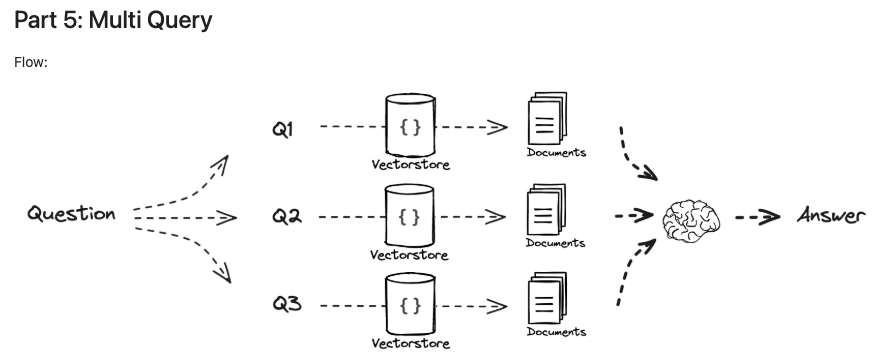

In [55]:
from langchain_classic.retrievers.multi_query import MultiQueryRetriever
from langchain_community.cross_encoders import HuggingFaceCrossEncoder
from langchain_classic.retrievers import ContextualCompressionRetriever
from langchain_classic.retrievers.document_compressors import CrossEncoderReranker



def get_retriever_multiQuery(
    vstore,
    llm,
    topk=20,
    reranker_top_n=20,
    score_threshold=0.8,
):
    """
    Create a Multi-Query + MMR retriever wrapped with a CrossEncoder reranker.

    Args:
        vstore: Chroma or compatible vectorstore.
        llm: LLM that generates multiple rewritten queries (e.g., ChatOpenAI, HuggingFacePipeline).
        topk (int): Number of docs retrieved per query.
        reranker_top_n (int): How many docs to rerank via cross-encoder.
        score_threshold (float): Min similarity score for vector retrieval.

    Returns:
        ContextualCompressionRetriever
    """

    # Step 1 — base retriever using MMR
    base_retriever = vstore.as_retriever(
        search_type="mmr",
        search_kwargs={"k": topk, "score_threshold": score_threshold}
    )

    # Step 2 — Multi-query retriever (query expansion)
    multi_query_retriever = MultiQueryRetriever.from_llm(
        retriever=base_retriever,
        llm=llm
    )

    # Step 3 — Cross-encoder model for reranking
    cross_encoder = HuggingFaceCrossEncoder(model_name="BAAI/bge-reranker-base")
    reranker = CrossEncoderReranker(model=cross_encoder, top_n=reranker_top_n)

    # Step 4 — Wrap everything in a compression retriever
    final_retriever = ContextualCompressionRetriever(
        base_retriever=multi_query_retriever,
        base_compressor=reranker
    )

    return final_retriever


In [63]:
#len(retriever_docs)
#!pip show langchain

In [59]:

def get_topk_relevant_documents(query, retriever):
    return retriever.invoke(query)

In [60]:
retriever = get_retriever(vector_store, 10)

In [61]:
retriever_multiQuery = get_retriever_multiQuery(vector_store, llm)

In [62]:
retriever_docs = get_topk_relevant_documents("what is the life insurance coverage for sport injury?", retriever)

In [67]:
retriever_docs_multiQuery = get_topk_relevant_documents("what is the life insurance coverage for sport injury?", retriever_multiQuery)

In [68]:
# print one page content
retriever_docs[0]

Document(id='b23dff92-139b-47dd-ac05-93b25f24fa2d', metadata={'creator': 'PyPDF', 'source': 'Policy+Documents/HDFC-Life-Easy-Health-101N110V03-Policy-Bond-Single-Pay.pdf', 'creationdate': '2021-11-29T10:03:02+00:00', 'moddate': '2021-12-09T06:23:28+00:00', 'page_label': '17', 'author': 'ANINDYAA', 'page': 16, 'producer': 'Microsoft: Print To PDF', 'total_pages': 33, 'title': 'HDFC Life Easy Health - 101N110V03 - Policy Bond (Single Pay)'}, page_content='20. Injury or Illness caused by violation or attempted violation of the law, or resistance to arrest; or by \nactive participation in an act with criminal intent. \n21. Injury or Illness caused by professional sports, racing of any kind, scuba   diving, aerial sports, \nactivities such as hand-gliding, ballooning, and any other hazardous activities or sports   unless agreed \nby special endorsement; \n22. Hospitalization where the Life Assured is a donor for any organ transplant; \n23. Any injury, sickness or disease received as a resul

In [69]:
# print one page content
retriever_docs_multiQuery[0]

Document(id='b23dff92-139b-47dd-ac05-93b25f24fa2d', metadata={'creationdate': '2021-11-29T10:03:02+00:00', 'author': 'ANINDYAA', 'page_label': '17', 'source': 'Policy+Documents/HDFC-Life-Easy-Health-101N110V03-Policy-Bond-Single-Pay.pdf', 'moddate': '2021-12-09T06:23:28+00:00', 'page': 16, 'creator': 'PyPDF', 'total_pages': 33, 'title': 'HDFC Life Easy Health - 101N110V03 - Policy Bond (Single Pay)', 'producer': 'Microsoft: Print To PDF'}, page_content='20. Injury or Illness caused by violation or attempted violation of the law, or resistance to arrest; or by \nactive participation in an act with criminal intent. \n21. Injury or Illness caused by professional sports, racing of any kind, scuba   diving, aerial sports, \nactivities such as hand-gliding, ballooning, and any other hazardous activities or sports   unless agreed \nby special endorsement; \n22. Hospitalization where the Life Assured is a donor for any organ transplant; \n23. Any injury, sickness or disease received as a resul

In [33]:
# method for combining all relevant page content
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

#### Chains

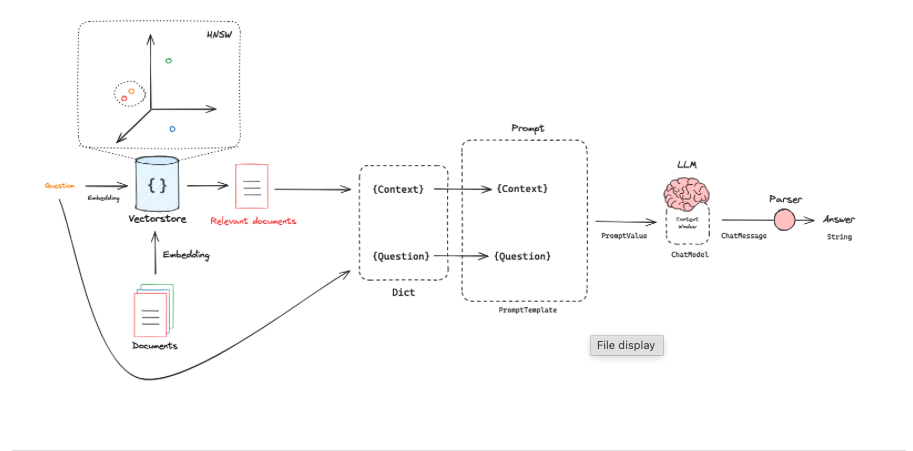



Using an LLM in isolation is fine for simple applications, but more complex applications require chaining LLMs - either with each other or with other components.

LangChain provides Chains that can be used to combine multiple components together to create a single, coherent application.

For example, we can create a chain that takes user input, formats it with a PromptTemplate, and then passes the formatted response to an LLM. We can build more complex chains by combining multiple chains together, or by combining chains with other components.

The fundamental unit of Chains is a LLMChain object which takes an input and provides an output.

Let's now create a simple LLMChain that takes an input, formats it, and passes it to an LLM for processing. The basic components are PromptTemplate, input queries, an LLM, and optional output parsers.

In [81]:
from langchain_core.prompts import PromptTemplate


In [82]:
rag_prompt = PromptTemplate(
    input_variables=["context", "question"],
    template="""
You are a highly intelligent and reliable AI assistant powered by Google's Gemini model.

Your task is to answer user questions using ONLY the information provided in the context below.

---------------------
CONTEXT:
{context}
---------------------

USER QUESTION:
{question}

GUIDELINES:
- If the answer is directly available in the context, provide a clear and concise response.
- If the context does not contain enough information, say:
  "The provided context does not contain this information."
- Do NOT make up facts or add external knowledge unless it's general reasoning.
- Prefer step-by-step clarity and factual accuracy.
- Keep the answer helpful, honest, and grounded in the context.

FINAL ANSWER:
"""
)


In [83]:
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser

retriever = get_retriever(vector_store, 50)
rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | rag_prompt
    | llm
    | StrOutputParser()
)

In [84]:
# test a query
query = "what is the minimum age for doing a term insurance?"
rag_chain.invoke(query)

'The provided context states that a person is eligible to participate in the Scheme if they are "not aged less than the minimum entry age as set out in the Policy Schedule." However, the specific minimum entry age is not provided in the given context.'

In [85]:

# test a query
query = "what is the life insurance coverage for sport injury?"
rag_chain.invoke(query)

'Life insurance coverage for sport injury is generally excluded if the injury or illness is caused by professional sports, racing of any kind, scuba diving, aerial sports, activities such as hand-gliding, ballooning, and any other hazardous activities or sports, unless agreed by special endorsement.\n\nThe policy also explicitly lists engaging in or taking part in professional sport(s) or any hazardous pursuits like power boat racing, sky diving, para gliding, parachuting, scuba diving, skydo riding, winter sports, sky jumping, ice hockey, ice speedway, ballooning, hand gliding, river rafting / bugging, black water rafting, yachting / boating outside coastal waters, motor rallying, power lifting, quad biking, rodeo and roller hockey as exclusions.'

In [86]:
# test a query
query = "Can a 100 year plus person do a term insurance?"
rag_chain.invoke(query)

'The provided context indicates a "Maximum Maturity Age Life Option" of 80 years and "Maximum Maturity Age Extra Life Option & Accelerated Critical Illness Option" of 75 years. Therefore, a person over 100 years old cannot do a term insurance as per this context.'

In [87]:
# test another query
query = "what is condition of deatht while not wearing Seat Belt?"
rag_chain.invoke(query)

'The provided context does not contain this information.'

In [88]:
# test another query
query = "what is the life insurance coverage for disability?"
rag_chain.invoke(query)

'The provided context does not contain this information.'

In [78]:
# test another query
query = "what is criteria for HDFC group insurance?"
rag_chain.invoke(query)

'The provided context does not contain this information.'

In [79]:
# test another query
query = "what are the benifits of HDFC Sampoorna-Jeevan insurance?"
rag_chain.invoke(query)

'The provided context states that HDFC Life Sampoorna Jeevan Plan is a non-linked participating individual life insurance savings Policy.\n\nThe benefits mentioned in the context for this policy include:\n*   **Participation in the surplus (profits) of the Company** for the Policyholder.\n*   The Policy Schedule lists components related to benefits such as:\n    *   Basic Sum Assured\n    *   Sum Assured on Death\n    *   Guaranteed Benefit Option (which can be Lumpsum, Income, Lumpsum with Income, or Income with Lumpsum)\n    *   Guaranteed Income Benefit (GIB)\n    *   Bonus Option (which can be SRB, SRIB, Cash, SRB+Cash, or SRIB+Cash)\n\nHowever, the context does not provide a detailed description of what each of these benefits entails or how they are calculated.'

In [80]:
# test another query
query = "what are HDFC Life Sanchay Plus Life Long Income Option?"
rag_chain.invoke(query)

'The provided context does not contain this information.'

#### RAG Agents

One formulation of a RAG application is as a simple agent with a tool that retrieves information. We can assemble a minimal RAG agent by implementing a tool that wraps our vector store:


A common approach is a two-step chain, in which we always run a search (potentially using the raw user query) and incorporate the result as context for a single LLM query. This results in a single inference call per query, buying reduced latency at the expense of flexibility.
In this approach we no longer call the model in a loop, but instead make a single pass.
We can implement this chain by removing tools from the agent and instead incorporating the retrieval step into a custom prompt

In [105]:
from langchain.agents.middleware import dynamic_prompt, ModelRequest
from langchain.agents import create_agent
from langgraph.checkpoint.memory import InMemorySaver

# ---------- 2-Step RAG Middleware ----------
@dynamic_prompt
def rag_middleware(request: ModelRequest) -> str:
    """
    Step 1: Retrieve context using the latest user query.
    Step 2: Inject retrieved context into a system message given to the model.
    """
    # Get latest user message
    last_query = request.state["messages"][-1].text

    # Use your custom retriever
    retrieved_docs = retriever.invoke(last_query)

    # Combine content
    docs_content = "\n\n".join(doc.page_content for doc in retrieved_docs)

    # System message that becomes step 1 of the chain
    system_message = (
        "You are a helpful RAG assistant. Use ONLY the context provided below "
        "to answer the question.\n\n"
        f"Context:\n{docs_content}\n"
    )

    return system_message


In [106]:
# -----------------------------
# 2. (Optional) RAG Tool
# -----------------------------
@tool
def retrieve_context(query: str):
    """Return raw retrieved documents as a fallback tool."""
    docs = retriever.invoke(query)
    combined = "\n\n".join(doc.page_content for doc in docs)
    return combined

In [107]:

# ---------- Create 2-Step RAG Agent ----------
rag_agent = create_agent(
    model=llm, 
    tools=[retrieve_context], # Optional for simple 2-step chain, but helpful
    middleware=[rag_middleware],
    checkpointer=InMemorySaver(),# <-- Short-term memory added,# <-- Short-term memory added
)

In [112]:
def rag_agent_query(
    agent,
    user_message: str,
    thread_id: str = "session-1"
):
    """Invoke any RAG agent with short-term memory support."""
    return agent.invoke(
        {"messages": [{"role": "user", "content": user_message}]},
        {"configurable": {"thread_id": thread_id}},
    )



In [115]:
# Example usage
rag_agent_query(rag_agent, "what are HDFC Life Sanchay Plus Life Long Income Option?")

{'messages': [HumanMessage(content='what are HDFC Life Sanchay Plus Life Long Income Option?', additional_kwargs={}, response_metadata={}, id='b79caae6-0fc5-4be2-a659-5cb3e43004a6'),
  AIMessage(content=[{'type': 'text', 'text': 'The HDFC Life Sanchay Plus plan offers a Maturity Benefit as a Guaranteed Income on Maturity. This income is payable at the end of each Income Payout Frequency as specified in the Policy Schedule. The Guaranteed Income starts from the (Policy Term + 1)th year and continues until the individual attains 99 years of age, provided all due premiums have been paid. At the end of the Payout Period, the policy terminates with the return of the Total Premiums paid. For the specific Guaranteed Income on Maturity value, you should refer to your Policy Schedule.', 'extras': {'signature': 'CrkCAXLI2nyell/+B2thCRVzyQmzQJCS4r2T2G7genn1pIRsPZevsqw3BzaPLCdTE0Gc1n5YdxmWydB6+kgAmVnSDi5ubME2qRJh4JIG6W6VmhyZEPiZjBE005GJoRW3yCdm/XJUg0lOwLgwvB9ydEm6arlfe136hmR9ARGwY1kZaAchLV5mwKsezN

### Final Thoughts
As we delve into the realm of advanced language processing, the evolution of RAG systems stands out as a testament to innovation and progress. The rapid development of more sophisticated paradigms has not only enabled customization but also furthered the performance and utility of RAG across diverse domains. From hybrid methodologies to self-retrieval techniques, researchers are exploring a myriad of avenues to enhance the capabilities of these models.

One crucial aspect that has gained attention is the role of rerankers in enhancing RAG efficacy. By refining the two-stage retrieval process through innovative approaches like FLARE, S2A, and reranking, RAG systems are now able to provide much better responses. The demand for better evaluation methodologies underscores the need for continuous improvement and refinement in RAG systems.